In [48]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv("data/preprocessed_books.csv")

In [3]:
df

,User-ID,ISBN,Book-Rating,title,author,rating,description,pages,awards,numRatings,...,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price
0,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,3.57,Little Altars Everywhere is a national best-se...,288,0,28611,...,1,0,0,0,0,1,0,0,0,3.39000
1,276747,0671537458,9,Waiting to Exhale,Terry McMillan,3.98,The story of friendship between four African A...,448,0,14718,...,1,0,0,0,0,0,0,0,0,0.89000
2,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,4.09,Published to international critical and popula...,483,1,68404,...,0,1,0,0,0,1,0,0,0,3.33000
3,276755,0451166892,5,The Pillars of the Earth,Ken Follett,4.31,Ken Follett is known worldwide as the master o...,976,0,648793,...,0,1,0,0,1,1,0,0,0,6.66651
4,276762,0380711524,5,See Jane Run,Joy Fielding,3.92,What do you do when you don't know who you are...,416,0,8008,...,1,0,1,1,0,0,0,0,0,2.86000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58532,276681,0060938455,9,Fast Food Nation: The Dark Side of the All-Ame...,Eric Schlosser,3.75,Fast food has hastened the malling of our land...,399,1,197560,...,0,0,0,0,0,0,0,0,0,3.09000
58533,276688,0553566040,6,Missing Joseph,Elizabeth George,3.96,Deborah and Simon St. James have taken a holid...,576,0,11641,...,0,1,1,1,0,0,0,0,0,7.51000
58534,276688,0553575104,6,In Pursuit of the Proper Sinner,Elizabeth George,4.10,A theatrical producer shoots himself on the ni...,718,0,12659,...,0,1,1,1,1,0,0,0,0,2.86000
58535,276688,0684804484,10,No Ordinary Time: Franklin and Eleanor Rooseve...,Doris Kearns Goodwin,4.18,"Winner of the Pulitzer for History, No Ordinar...",633,2,40982,...,0,0,0,0,0,1,0,0,0,7.08000


# Rating Creation

We want to combine all rating, award and score information into one metric, so we can evaluate and compare books against each other as accurately as possible.

Let's make the bbeVotes a relative score:

In [4]:
def standardize(series): 
    return 100 * (series - series.min()) / series.max()

In [5]:
df["bbePopularity"] = np.ceil(standardize(df["bbeVotes"]))
df["bbePopularity"]

0         1.0
1         1.0
2         1.0
3        19.0
4         1.0
         ... 
58532     1.0
58533     1.0
58534     1.0
58535     1.0
58536     1.0
Name: bbePopularity, Length: 58537, dtype: float64

Let's transform the rating into percentage:

In [6]:
df["rating"] = standardize(df["rating"] * 100 / 5)
df["rating"]

0        23.6
1        31.8
2        34.0
3        38.4
4        30.6
         ... 
58532    27.2
58533    31.4
58534    34.2
58535    35.8
58536    24.8
Name: rating, Length: 58537, dtype: float64

In [7]:
df["awards"].value_counts()

awards
0     33601
1     11271
2      5454
3      2044
4      1883
5      1374
9       604
6       589
8       539
7       374
13      317
10      156
11      134
12       93
22       47
15       42
16        6
17        3
25        2
14        2
28        1
21        1
Name: count, dtype: int64

We can transform the values into ordinal categories:

In [8]:
# Define the bin edges
bins = [0, 0.99, 4.99, 9.99, 29.99]

# Define the labels for the bins
labels = [15, 60, 85, 100]

# Categorize the numeric column into ordinal categories
df["awards"] = pd.cut(df["awards"], bins=bins, labels=labels, right=False).astype(int)

In [9]:
df["awards"].value_counts()

awards
15     33601
60     20652
85      3480
100      804
Name: count, dtype: int64

We will evaluate the books (in percentage) based on the following formula:

- 30% - liked percentage
- 35% - rating
- 15% - BBE popularity
- 20% - awards

In [10]:
df["overall_rating"] = standardize(df["likedPercent"] * 30 + df["rating"] * 35 + df["bbePopularity"] * 15 + df["awards"] * 20)

[]

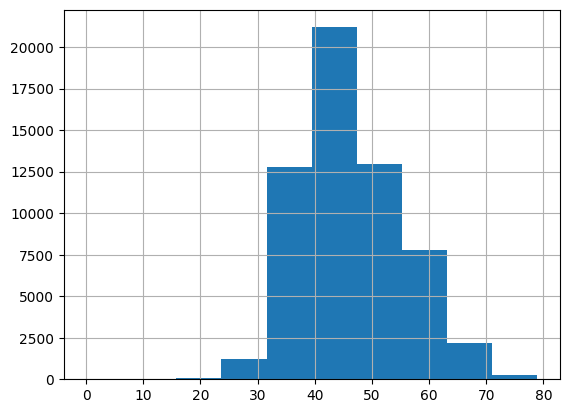

In [11]:
df["overall_rating"].hist()
plt.plot()

In [12]:
book_df = df.copy()
book_df = book_df.drop(columns=["User-ID", "Book-Rating"])
book_df.drop_duplicates(inplace=True)
book_df.reset_index(inplace=True, drop=True)

In [13]:
book_df

,ISBN,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,bbePopularity,overall_rating
0,0060517794,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,0,1,0,0,0,3.390000,1.0,33.768873
1,0671537458,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,...,0,0,0,0,0,0,0,0.890000,1.0,40.548780
2,0679776818,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,...,0,0,0,1,0,0,0,3.330000,1.0,54.297329
3,0451166892,The Pillars of the Earth,Ken Follett,38.4,Ken Follett is known worldwide as the master o...,976,15,648793,95.0,392260,...,0,0,1,1,0,0,0,6.666510,19.0,48.257840
4,0380711524,See Jane Run,Joy Fielding,30.6,What do you do when you don't know who you are...,416,15,8008,93.0,173,...,1,1,0,0,0,0,0,2.860000,1.0,39.503484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,0689843240,The Great Good Thing,Roderick Townley,30.4,"Sylvie had an amazing life, but she didn't get...",224,15,2352,91.0,79,...,0,0,0,0,1,1,1,2.360000,1.0,38.530778
7614,0446356050,Promises to Keep,Ann Tatlock,31.0,Eleven-year-old Roz (Rosalind) Anthony and her...,348,15,1997,95.0,87,...,0,0,0,1,0,0,0,4.230000,1.0,40.577816
7615,0425185508,Picture Perfect,Camille Dixon,24.2,"On the outside, Devin Thompson looks like he h...",308,15,308,86.0,94,...,0,0,0,0,0,0,0,7.125528,1.0,33.202671
7616,0803727356,The River Between Us,Richard Peck,27.6,The year is 1861. Civil war is imminent and Ti...,164,60,4340,91.0,85,...,0,0,0,1,0,0,1,7.500000,1.0,50.174216


[]

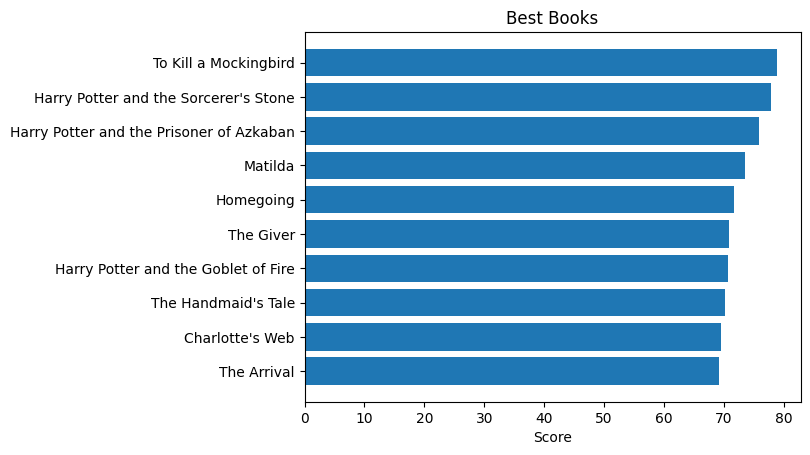

In [14]:
plt.barh(
    book_df.sort_values("overall_rating", ascending=False)["title"].head(10),
    book_df.sort_values("overall_rating", ascending=False)["overall_rating"].head(10), 
    align="center"
)
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Best Books")
plt.plot()

# Content Based Filtering

## TF-IDF

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=30_000, dtype=np.float32)
book_df["description"] = book_df["description"].fillna("")
tfidf_matrix = tfidf_vectorizer.fit_transform(book_df["description"])
tfidf_matrix.shape

(7618, 30000)

In [16]:
title_to_index = pd.Series(book_df.index, index=book_df["title"]).drop_duplicates()

In [17]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
def get_recommendations(title, similarity):
    idx = title_to_index[title]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores.sort(key=lambda X: X[1], reverse=True)
    sim_scores = sim_scores[1:11]
    indices = [i[0] for i in sim_scores]
    return book_df["title"].iloc[indices]

In [33]:
get_recommendations("Harry Potter and the Prisoner of Azkaban", cosine_sim)

2561              Harry Potter and the Chamber of Secrets
5510                Harry Potter and the Sorcerer's Stone
3603                  Harry Potter and the Goblet of Fire
6878    Harry Potter Schoolbooks Box Set: Two Classic ...
3999                                               Pronto
3305                                    Star in the Storm
6064                                        Into the Blue
2723              Fantastic Beasts and Where to Find Them
2449                                          Blood Rites
4554                               Absolutely, Positively
Name: title, dtype: object

In [34]:
def get_genres(row):
    genres = ["Fiction", "Novels", "Adult", "Mystery", "Contemporary", "Thriller", "Romance",
              "Classics", "Suspense", "Fantasy", "Historical Fiction", "Adult Fiction", "Literature", "Mystery Thriller",
              "Crime", "Audiobook", "Historical", "Adventure", "Science Fiction", "Young Adult"]
    current_genres = ""
    for genre in genres:
        if row[genre] == 1:
            current_genres += genre + ", "
    return current_genres

In [42]:
def get_characteristics(x):
    return get_genres(x) + x["author"] + x["description"]

book_df["combined_characteristics"] = book_df.apply(get_characteristics, axis=1)

In [43]:
book_df

,ISBN,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,bbePopularity,overall_rating,combined_characteristics
0,0060517794,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,1,0,0,0,3.390000,1.0,33.768873,"Fiction, Novels, Adult, Contemporary, Historic..."
1,0671537458,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,...,0,0,0,0,0,0,0.890000,1.0,40.548780,"Fiction, Novels, Adult, Contemporary, Romance,..."
2,0679776818,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,...,0,0,1,0,0,0,3.330000,1.0,54.297329,"Fiction, Novels, Romance, Classics, Historical..."
3,0451166892,The Pillars of the Earth,Ken Follett,38.4,Ken Follett is known worldwide as the master o...,976,15,648793,95.0,392260,...,0,1,1,0,0,0,6.666510,19.0,48.257840,"Fiction, Novels, Adult, Classics, Fantasy, His..."
4,0380711524,See Jane Run,Joy Fielding,30.6,What do you do when you don't know who you are...,416,15,8008,93.0,173,...,1,0,0,0,0,0,2.860000,1.0,39.503484,"Fiction, Adult, Mystery, Contemporary, Thrille..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,0689843240,The Great Good Thing,Roderick Townley,30.4,"Sylvie had an amazing life, but she didn't get...",224,15,2352,91.0,79,...,0,0,0,1,1,1,2.360000,1.0,38.530778,"Fiction, Adult, Fantasy, Adventure, Science Fi..."
7614,0446356050,Promises to Keep,Ann Tatlock,31.0,Eleven-year-old Roz (Rosalind) Anthony and her...,348,15,1997,95.0,87,...,0,0,1,0,0,0,4.230000,1.0,40.577816,"Fiction, Mystery, Contemporary, Historical Fic..."
7615,0425185508,Picture Perfect,Camille Dixon,24.2,"On the outside, Devin Thompson looks like he h...",308,15,308,86.0,94,...,0,0,0,0,0,0,7.125528,1.0,33.202671,"Adult, Contemporary, Romance, Camille Dixon On..."
7616,0803727356,The River Between Us,Richard Peck,27.6,The year is 1861. Civil war is imminent and Ti...,164,60,4340,91.0,85,...,0,0,1,0,0,1,7.500000,1.0,50.174216,"Fiction, Adult, Historical Fiction, Historical..."


## Count Vectorizer

In [44]:
count_vectorizer = CountVectorizer(stop_words="english")
count_matrix = count_vectorizer.fit_transform(book_df["combined_characteristics"])

In [45]:
count_sim = linear_kernel(count_matrix, count_matrix)

In [46]:
get_recommendations("Harry Potter and the Prisoner of Azkaban", count_sim)

5510                Harry Potter and the Sorcerer's Stone
2561              Harry Potter and the Chamber of Secrets
6878    Harry Potter Schoolbooks Box Set: Two Classic ...
422                                           The Bottoms
7578    Leadership and the New Science: Discovering Or...
1541                                             Still Me
3603                  Harry Potter and the Goblet of Fire
3999                                               Pronto
6321                         The Complete Sherlock Holmes
2723              Fantastic Beasts and Where to Find Them
Name: title, dtype: object